In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
!pip install dataprep
sns.set_style('darkgrid')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

In [4]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [5]:
# Import Dataset
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (42, 2)


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [6]:
#--------------------------------Data Exploration--------------------------------------
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [9]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [8]:
df['Sales'].describe()

count      42.000000
mean     2994.353308
std       977.930896
min      1547.818996
25%      2159.714247
50%      2782.376999
75%      3609.250000
max      5253.000000
Name: Sales, dtype: float64

In [10]:
#Descriptive Analysis
df.shape

(42, 2)

In [11]:
#Checking the data types
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [12]:
#Unique values for every feature
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [13]:
#Feature Engineering
#Converting the Quarters into Years
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [14]:
#Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [15]:
#Extracting the Quarters and putting in column
df['Quarters'] = 0
for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]

df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [16]:
#Creating Dummy Variables for Quarters Variable
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [17]:
#Making the Date as DateTime index for the Dataframe
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [18]:
df1.head()

,Quarter,Sales,Quarter_Year,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,,,
1986-01-01,Q1_86,1734.827000,Q1 1986,Q1,1,0,0,0
1986-04-01,Q2_86,2244.960999,Q2 1986,Q2,0,1,0,0
1986-07-01,Q3_86,2533.804993,Q3 1986,Q3,0,0,1,0
1986-10-01,Q4_86,2154.962997,Q4 1986,Q4,0,0,0,1
1987-01-01,Q1_87,1547.818996,Q1 1987,Q1,1,0,0,0


In [19]:
#Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


In [20]:
#Data Visualization


<Axes: xlabel='month', ylabel='year'>

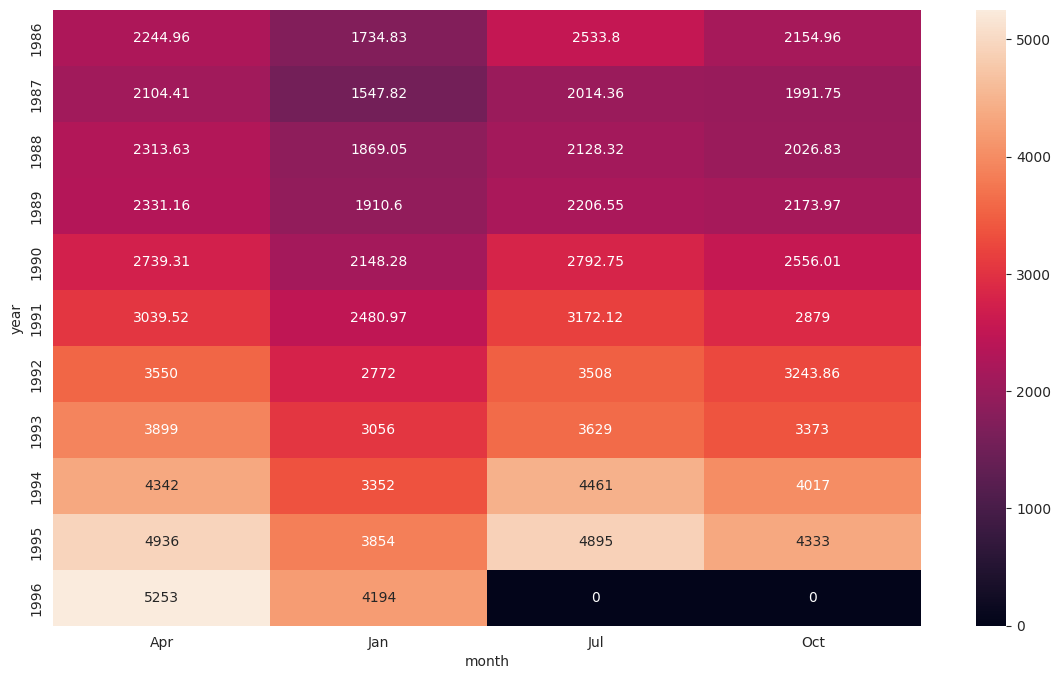

In [21]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

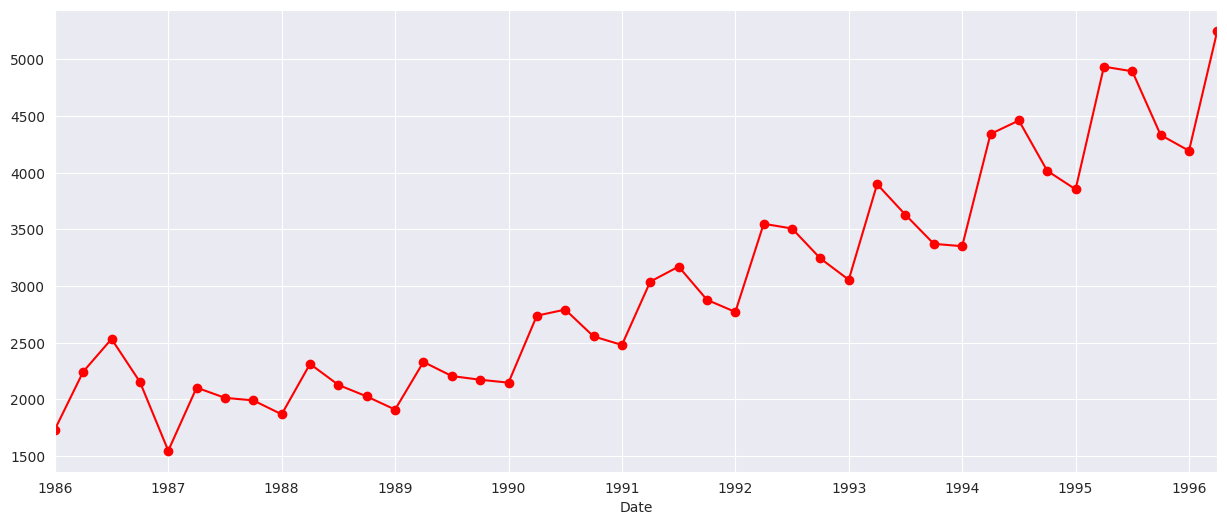

In [23]:
#Line plot
df1['Sales'].plot(figsize=(15, 6),color='red',marker='o')
plt.show()

In [25]:
'''
Observation:^
We can see that there is an increasing Trend. So, Trend is not constant.
Variance is also not constant.
Hence the time series is not stationary.
'''

'\nObservation:^\nWe can see that there is an increasing Trend. So, Trend is not constant.\nVariance is also not constant.\nHence the time series is not stationary.\n'

In [26]:
#Line Plot Using Quarters as Y axis and Sales as X axis

<Axes: xlabel='Quarters', ylabel='Sales'>

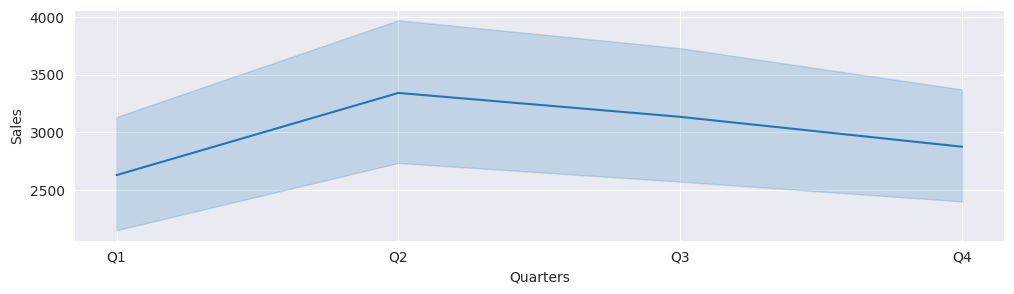

In [27]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

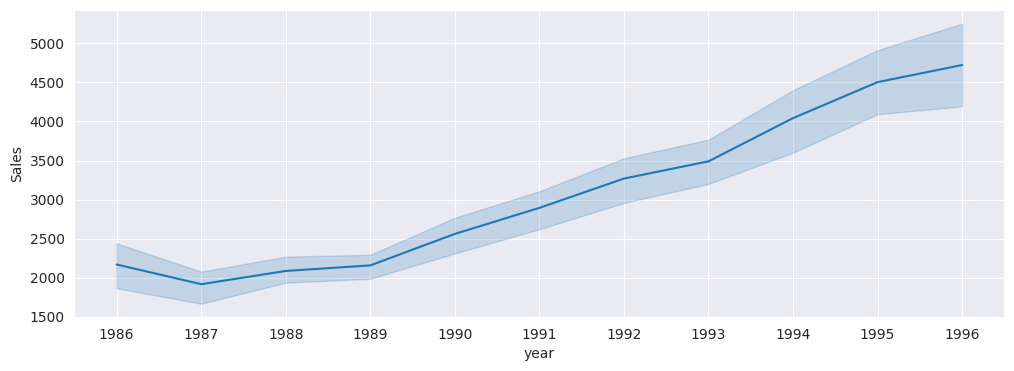

In [28]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [29]:
#Box Plot of Each Year by Quaterly Intervals

<Axes: xlabel='year', ylabel='Sales'>

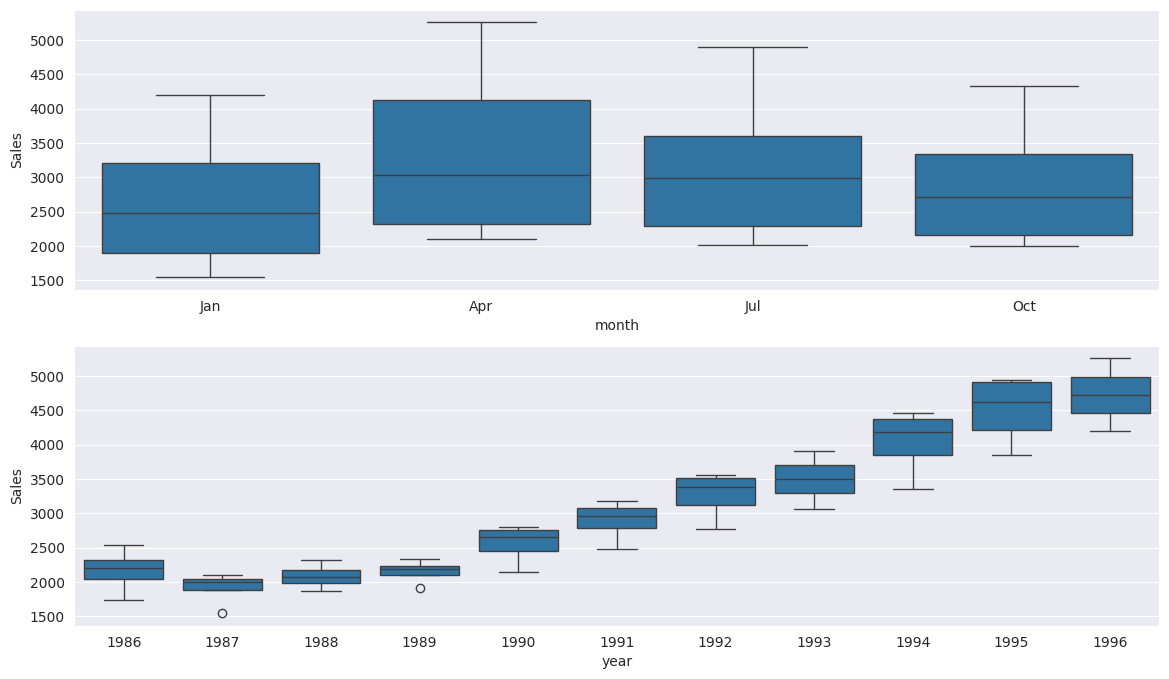

In [30]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

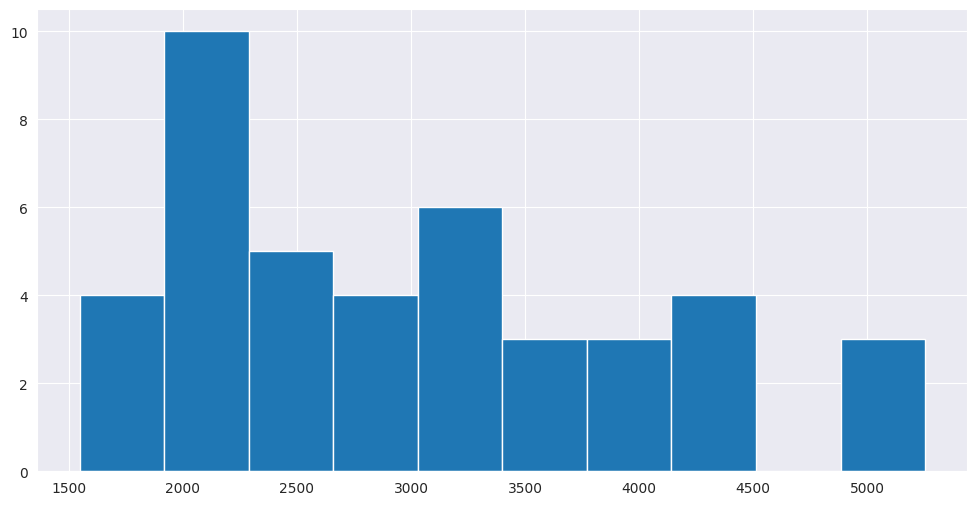

In [31]:
#Histogram and Density Plots
df.Sales.hist(figsize=(12,6))
plt.show()

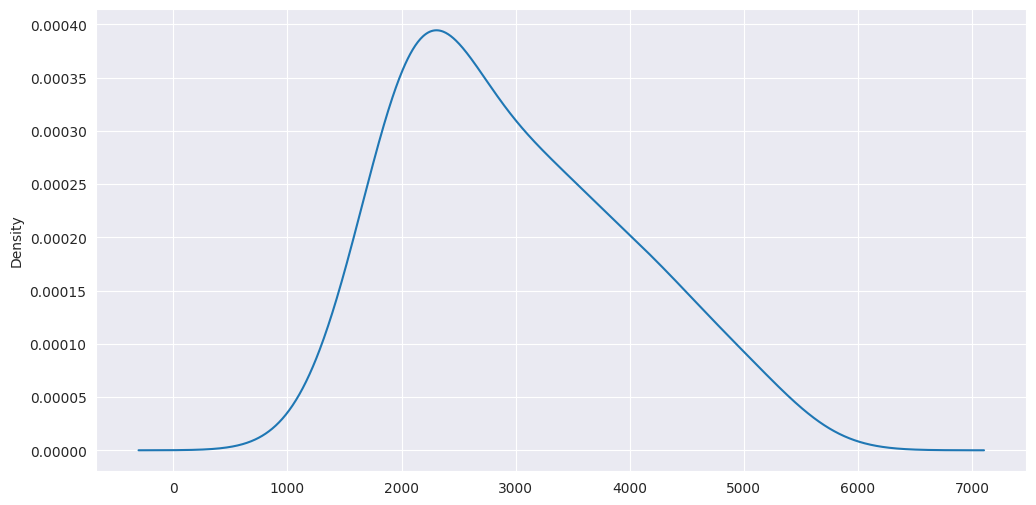

In [32]:
## create a density plot
df.Sales.plot(kind='kde', figsize=(12,6))
plt.show()

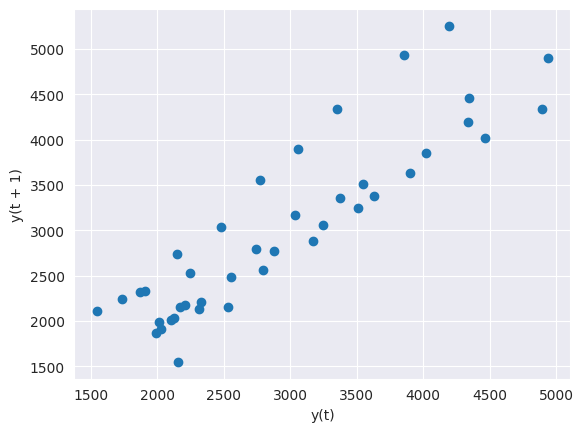

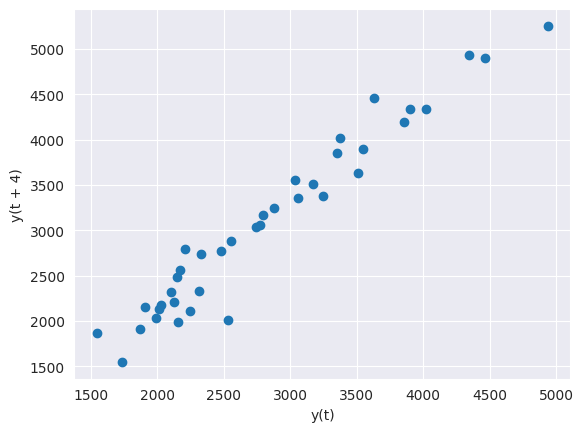

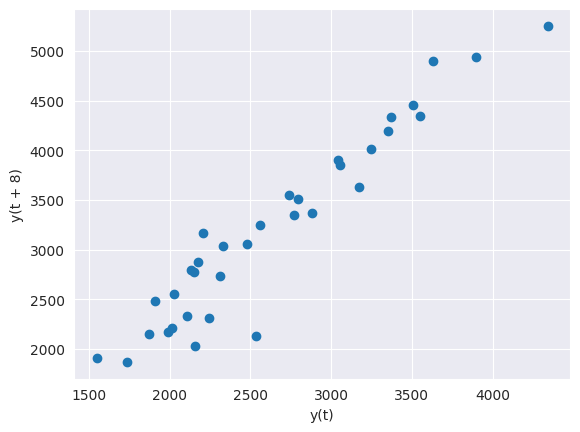

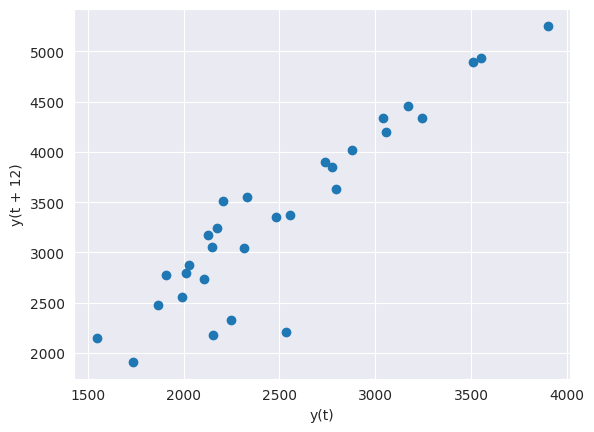

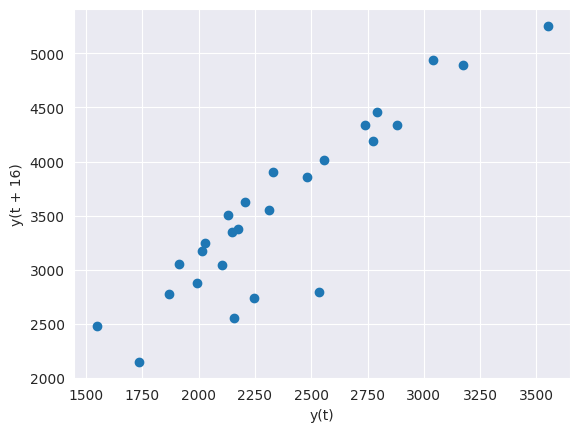

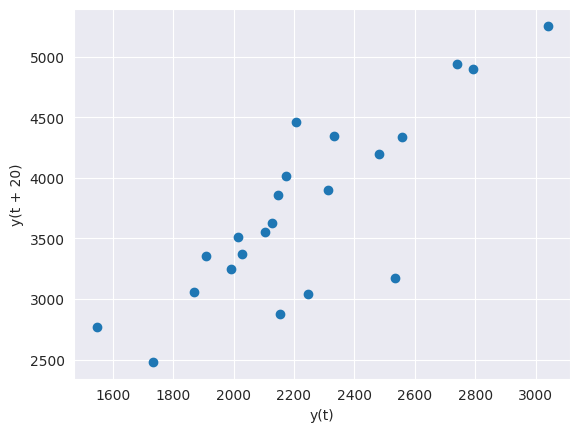

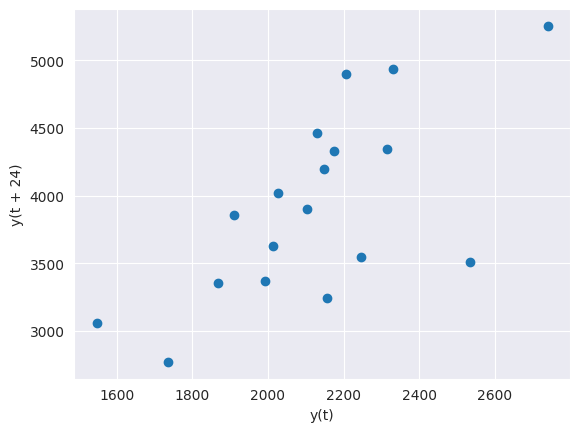

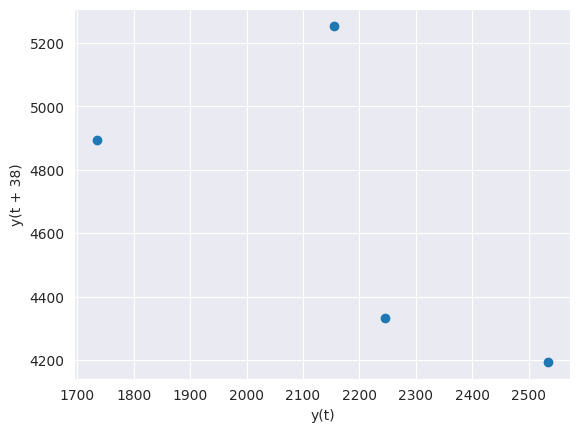

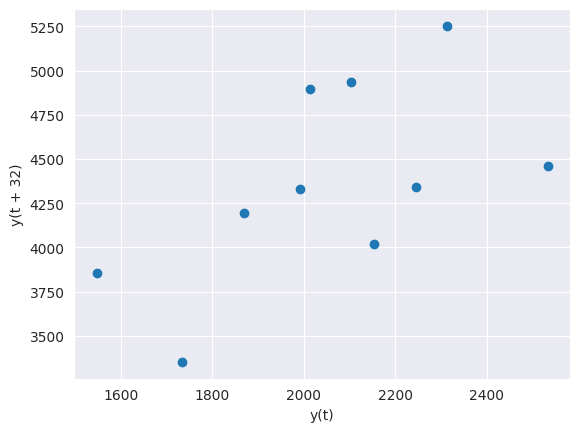

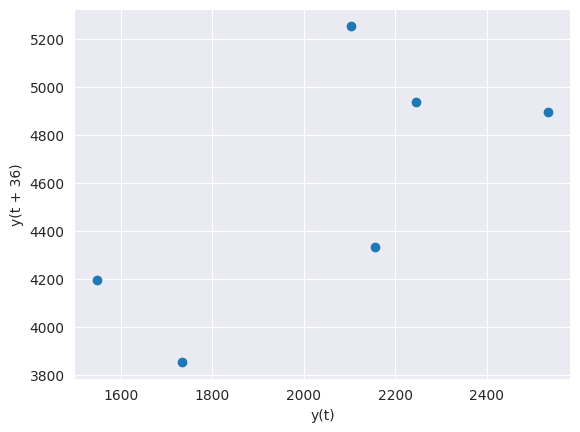

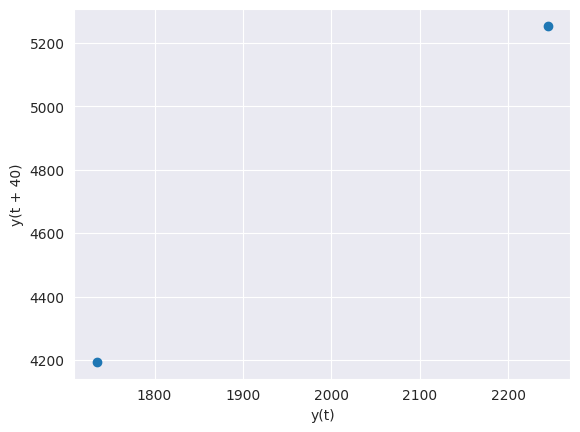

In [33]:
#Lag plot
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Sales, lag=i)
    plt.show()

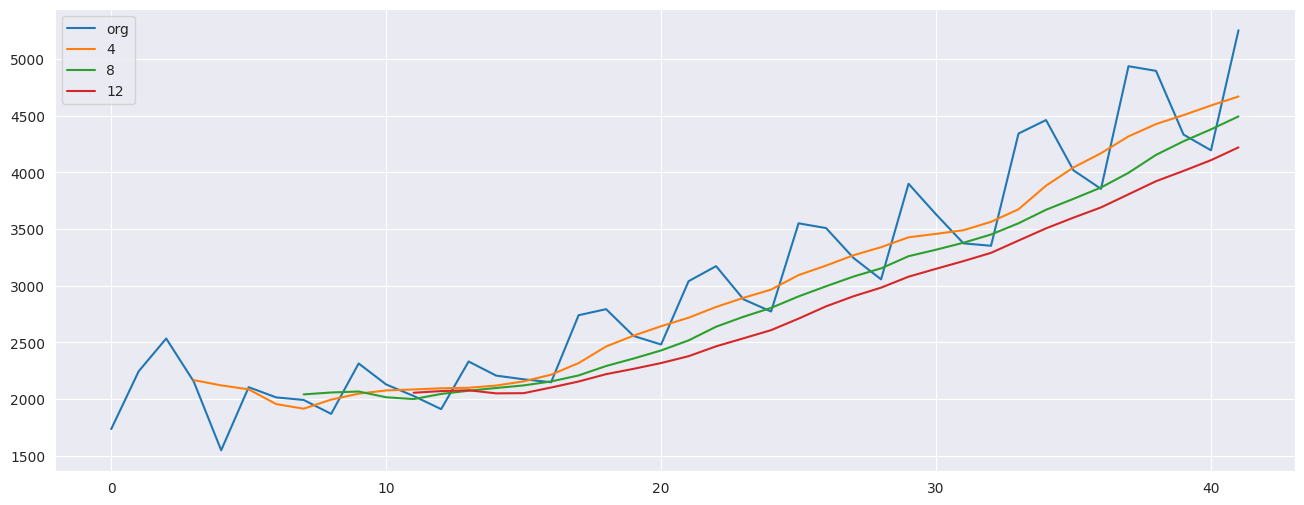

In [34]:
#Moving Average
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

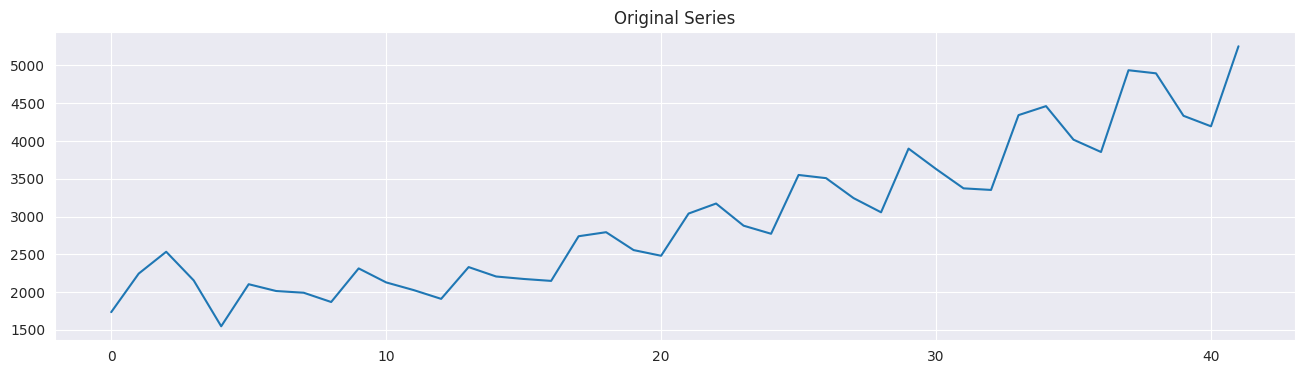

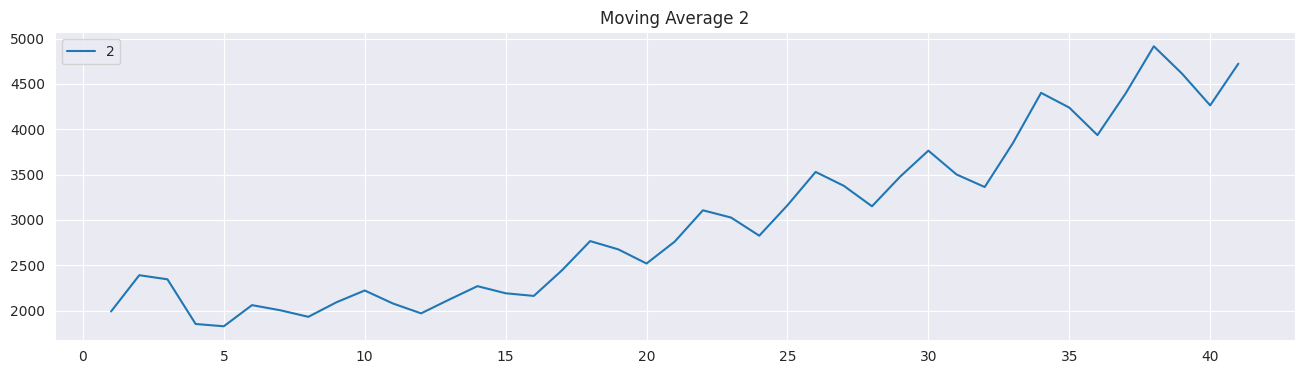

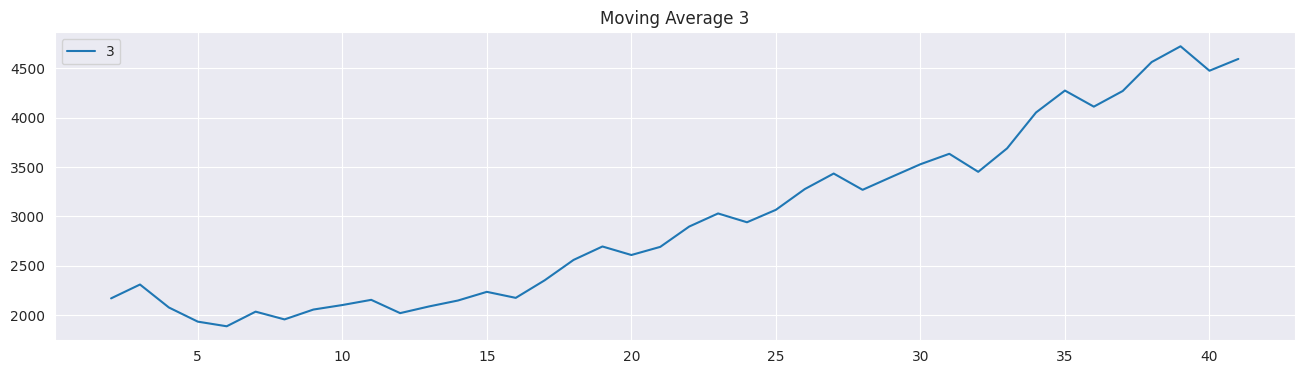

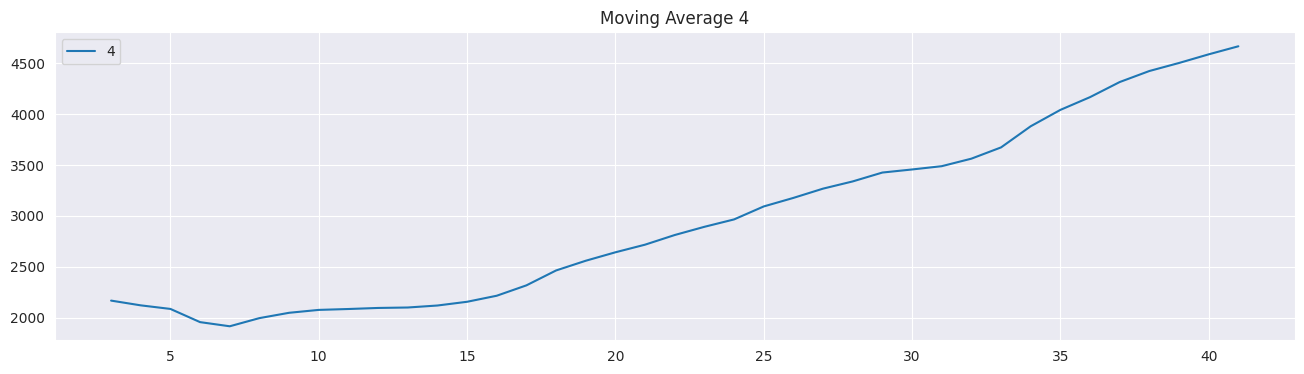

In [35]:
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

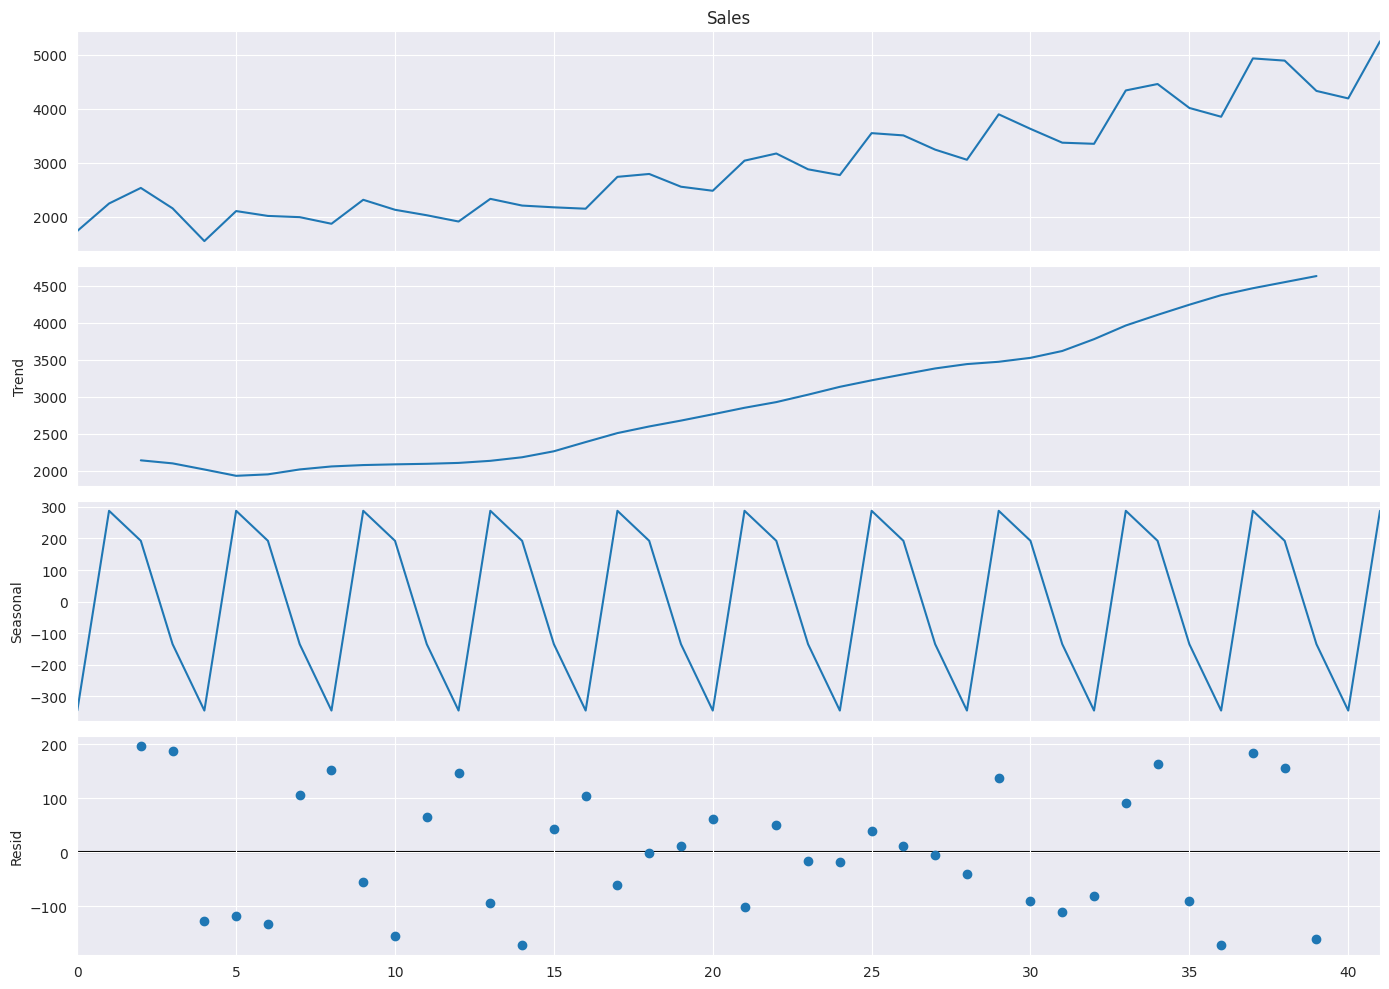

In [36]:
#Time series decomposition plot
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [38]:
#ACF plots and PACF plots
#Autocorrelation Function (ACF)

'''
The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series
are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units.
A lag corresponds to a certain point in time after which we observe the first value in the time series.
'''

'\nThe autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series \nare with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units. \nA lag corresponds to a certain point in time after which we observe the first value in the time series.\n'

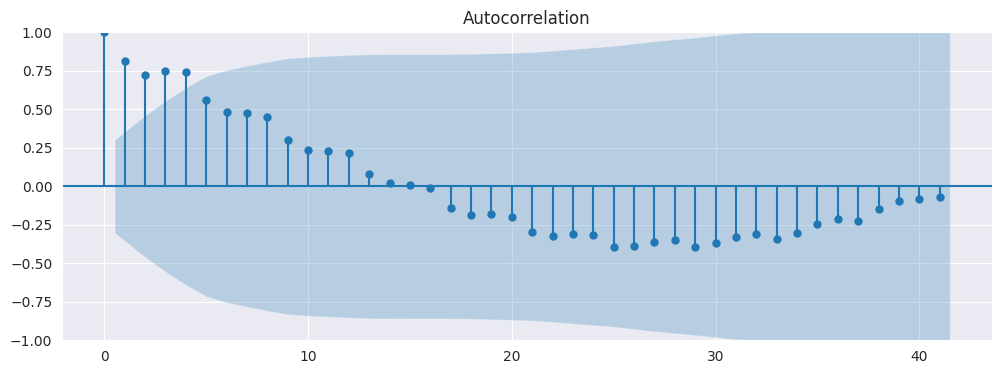

In [39]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    plt.show()

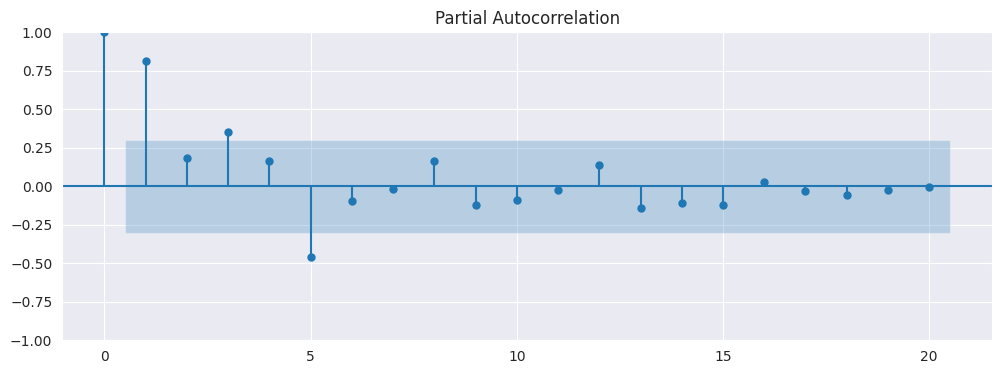

In [40]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

In [41]:
#To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

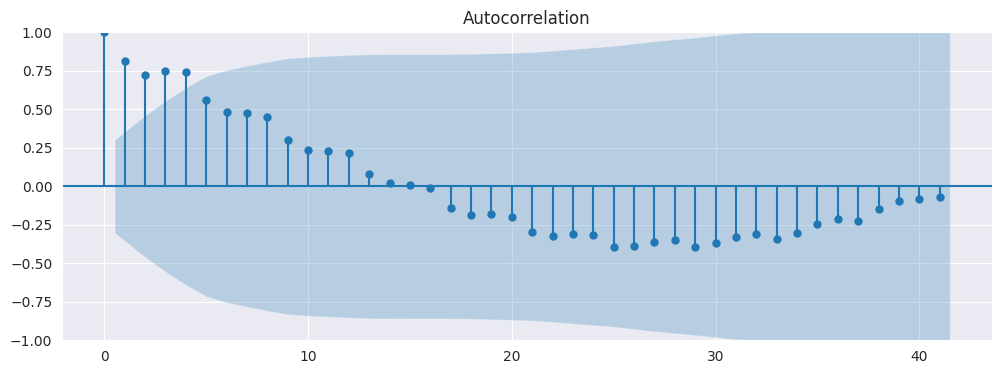

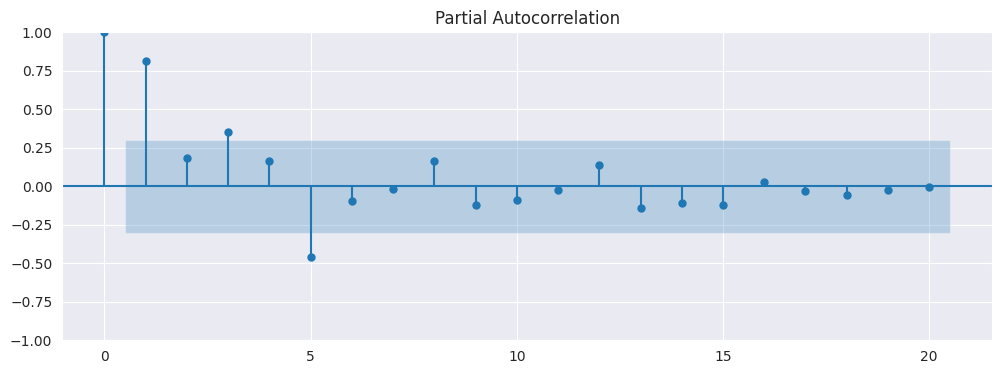

In [42]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

In [43]:
#--------------------------------------------Sampling------------------------------
#Linear interpolation

In [44]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


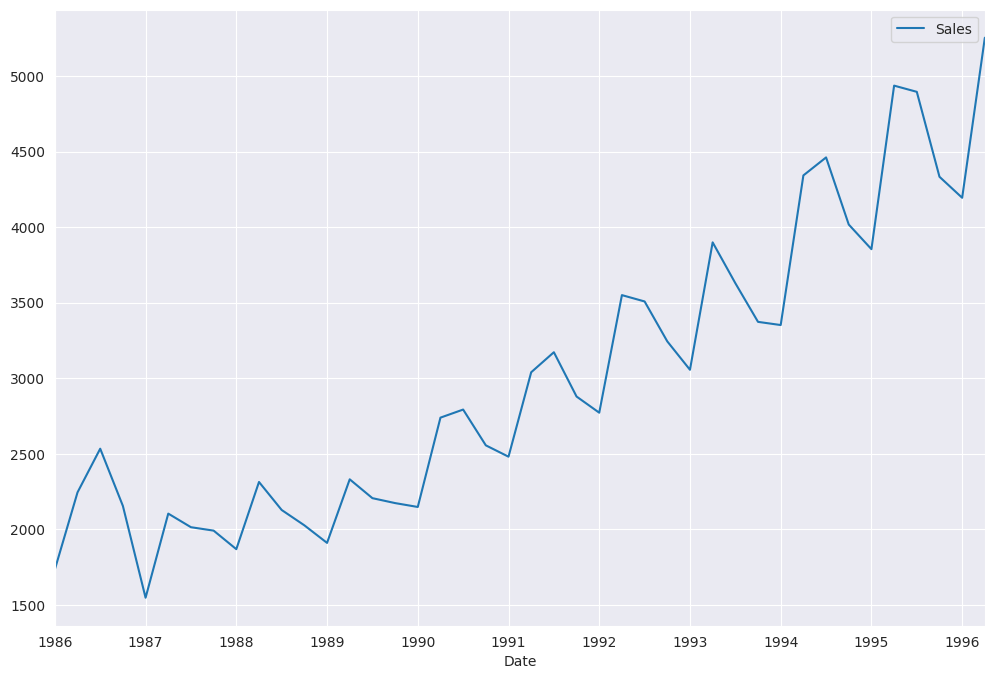

In [45]:
interpolated_month = upsampled_month.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(12,8))
plt.show()

In [46]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [47]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]

,Sales,date,year,month,week,quarter,day_of_week
0,1734.827000,1986-01-31,1986,1,5,1,Friday
1,1904.871666,1986-02-28,1986,2,9,1,Friday


In [48]:
# data
df_1986 = visual[visual['year']==1986][['month','Sales']]
df_1986 = df_1986.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1986'})
df_1987 = visual[visual['year']==1987][['month','Sales']]
df_1987 = df_1987.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1987'})
df_1988 = visual[visual['year']==1988][['month','Sales']]
df_1988 = df_1988.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1988'})
df_1989 = visual[visual['year']==1989][['month','Sales']]
df_1989 = df_1989.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1989'})
df_1990 = visual[visual['year']==1990][['month','Sales']]
df_1990 = df_1990.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1990'})
df_1991 = visual[visual['year']==1991][['month','Sales']]
df_1991 = df_1991.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1991'})
df_1992 = visual[visual['year']==1992][['month','Sales']]
df_1992 = df_1992.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1992'})
df_1993 = visual[visual['year']==1993][['month','Sales']]
df_1993 = df_1993.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1993'})
df_1994 = visual[visual['year']==1994][['month','Sales']]
df_1994 = df_1994.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1994'})
df_1995 = visual[visual['year']==1995][['month','Sales']]
df_1995 = df_1995.groupby('month').agg({"Sales" : "mean"}).reset_index().rename(columns={'Sales':'1995'})

df_year = df_1986.merge(df_1987,on='month').merge(df_1988,on='month').merge(df_1989,on='month').merge(df_1990,on='month')\
.merge(df_1991,on='month').merge(df_1992,on='month').merge(df_1993,on='month').merge(df_1994,on='month').merge(df_1995,on='month')

# top levels
top_labels = ['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']

colors = ['rgb(6, 19, 14)', 'rgb(18, 58, 43)',
          'rgb(31, 97, 71)', 'rgb(43, 136, 100)',
          'rgb(55, 174, 129)','rgb(81, 200, 154)',
          'rgb(119, 212, 176)','rgb(158, 224, 199)'
          ,'rgb(197, 237, 221)','rgb(236, 249, 244)']

# X axis value
df_year = df_year[['1986', '1987', '1988', '1989', '1990','1991','1992','1993','1994','1995']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_1986['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_1986['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))


fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False,
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack',
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False,
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

In [49]:
#Observation:
'''
Highest sales are made in June, July, May, April month and then decreases in January.
Sales are increasing gradually from 1986 to 1995.
Note: We don't have enough data for 1996
'''

"\nHighest sales are made in June, July, May, April month and then decreases in January.\nSales are increasing gradually from 1986 to 1995.\nNote: We don't have enough data for 1996\n"

In [50]:
# data
import calendar
df_m_sa = visual.groupby('month').agg({"Sales" : "mean"}).reset_index()
df_m_sa['Sales'] = round(df_m_sa['Sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['Sales'].astype(str)

df_w_sa = visual.groupby('week').agg({"Sales" : "mean"}).reset_index()
df_q_sa = visual.groupby('quarter').agg({"Sales" : "mean"}).reset_index()
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3],
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis",
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['Sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'),
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['Sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'),
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['Sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'),
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)],
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()


In [51]:
# data
df_dw_sa = visual.groupby('day_of_week').agg({"Sales" : "mean"}).reset_index()
df_dw_sa.Sales = round(df_dw_sa.Sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='Sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='Sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified",
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))

In [52]:
#Observation:
'''
As we saw in the above chart there is an upward trend in sales over the time.
 Although there are ups and downs at every point in time, generally we can observe that the trend increases.
 Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too.
 Let’s take a closer look by observing some year’s data:

Highest sales are made on Tuesday.
April month has the highest sales.
Note: We don't have enough data for 1996
'''

"\nAs we saw in the above chart there is an upward trend in sales over the time.\n Although there are ups and downs at every point in time, generally we can observe that the trend increases. \n Also we can notice how the ups and downs seem to be a bit regular, it means we might be observing a seasonal pattern here too. \n Let’s take a closer look by observing some year’s data:\n\nHighest sales are made on Tuesday.\nApril month has the highest sales.\nNote: We don't have enough data for 1996\n"

In [53]:
#Splitting Train and Test Data

#Leaving Test Data with 2 Years of Time Series

In [54]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [55]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


In [56]:
#We are going to forecat for the last two years. 1986 and 1994.

#Last 24 records contain 1994 and 1996 data.

<Axes: xlabel='Date'>

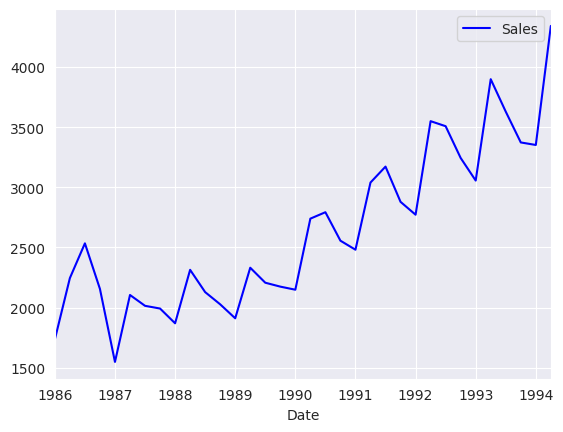

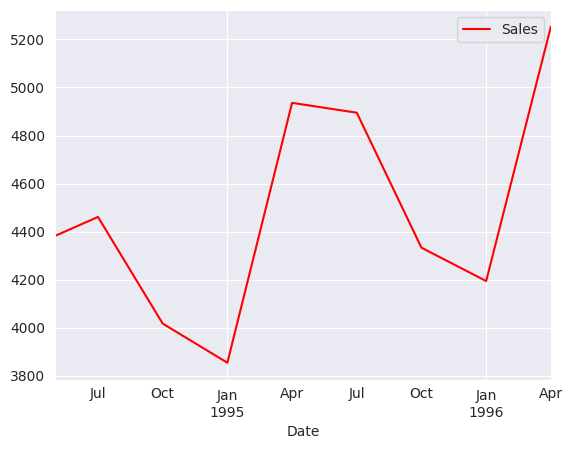

In [58]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST',color='red')

In [59]:
#---------------------------------------Evaluation Metric MAPE------------------------------------

In [60]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [61]:
#Exponential Methods
#Simple Exponential Method

In [62]:
#Using Forecast Attribute

In [63]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error = 381.95422355078995


In [64]:
#Using Predict Attribute

In [65]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error = 381.95422355078995


In [66]:
#Difference between Predict and Forecast attribute

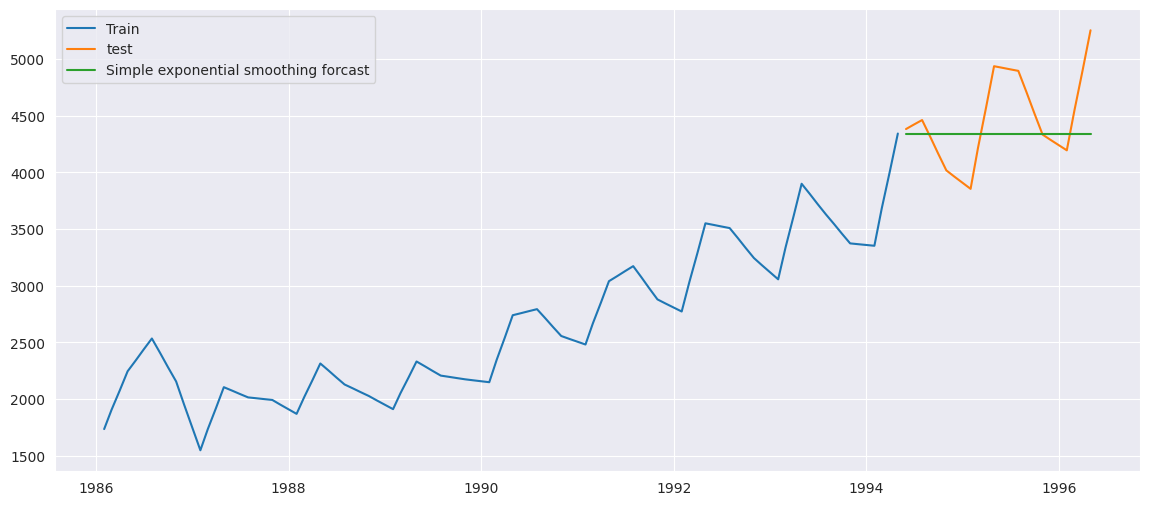

In [67]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [68]:
#Observation
#No seasonality captures.
#Most recent observation gets higher weightages than the older ones for forecasting.

In [69]:
#Holt method (Double Exponential)
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.4931606588976 
 Train Root Mean Squared Error = 108.70855330066725 
 Test Root Mean Squared Error = 4549.83259387513


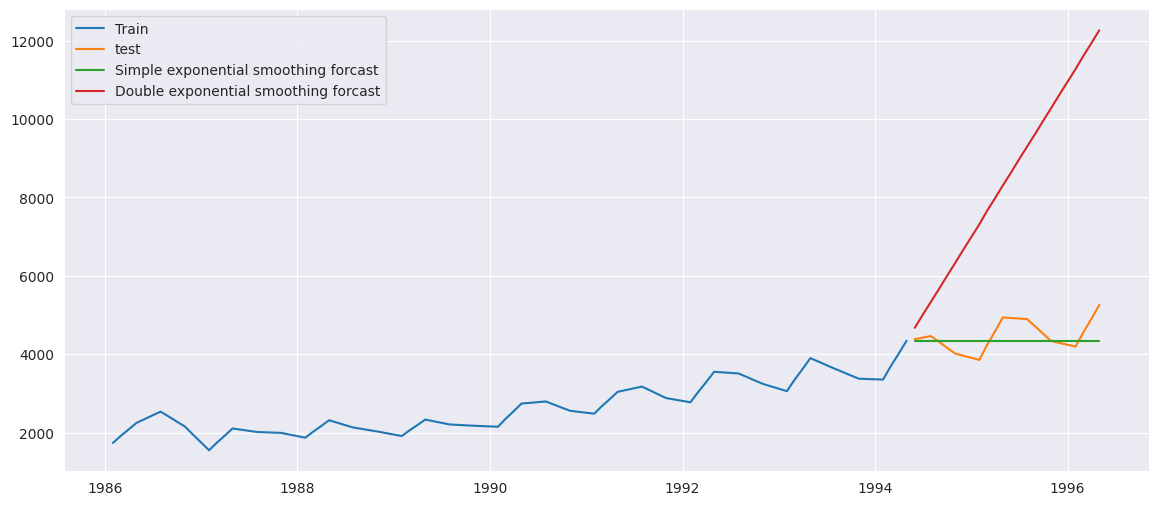

In [70]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [71]:
'''
Observation
We can see that we are able to capture the trend of the data but the level is on another level.
We were not able to capture the seasonality.
'''

'\nObservation\nWe can see that we are able to capture the trend of the data but the level is on another level.\nWe were not able to capture the seasonality.\n'

In [72]:
#Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

In [73]:
#Captures Level, Trend and Seasonality.

In [74]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 35.69571274324909 
 Train Root Mean Squared Error = 44.2653652251861 
 Test Root Mean Squared Error = 1828.4767720554398


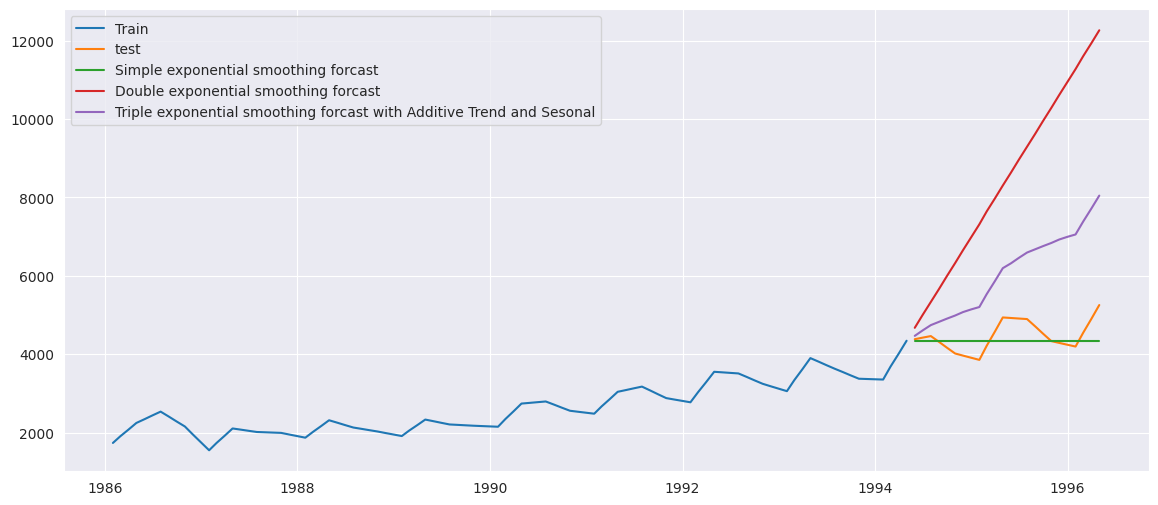

In [75]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

In [76]:
#Observation
'''
It captures the trend, which we can see that the forecasted values are higher level than the test level.
It also captures the seasonality.
The peak of the forecasted value is higher than the actual.
'''

'\nIt captures the trend, which we can see that the forecasted values are higher level than the test level.\nIt also captures the seasonality.\nThe peak of the forecasted value is higher than the actual.\n'

In [77]:
#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [80]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 1.487268775553493 
 Train Root Mean Squared Error = 50.223974444654 
 Test Root Mean Squared Error = 78.73325826552858


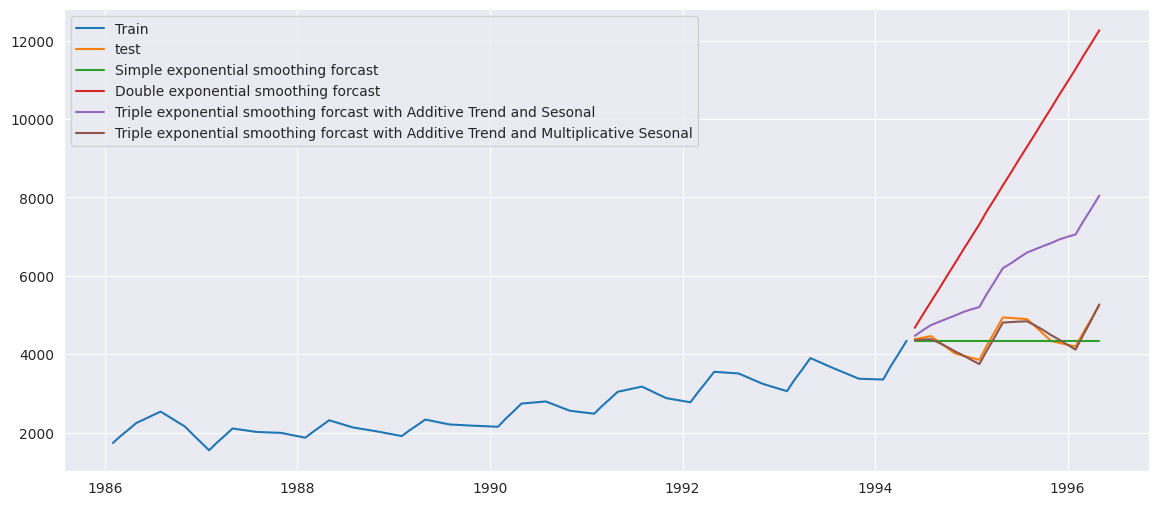

In [81]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

In [ ]:
'''
Observation
We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.
'''

In [82]:
#Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [83]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 5.168784154878948 
 Train Root Mean Squared Error = 165.78104360617877 
 Test Root Mean Squared Error = 270.08479145849486


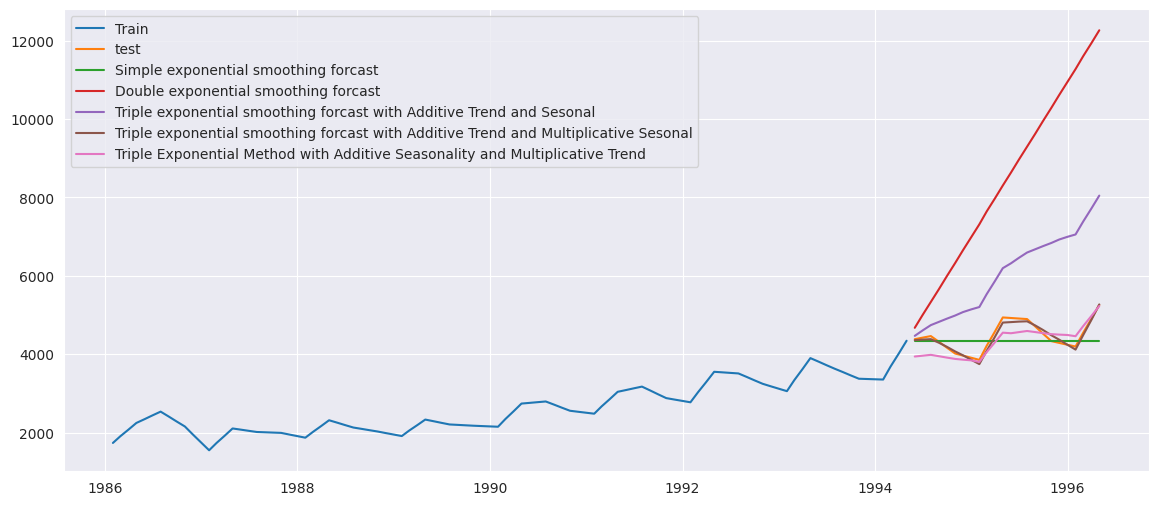

In [84]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

In [85]:
#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [86]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 1.8078233252851952 
 Train Root Mean Squared Error = 49.43910507382248 
 Test Root Mean Squared Error = 101.65134880354205


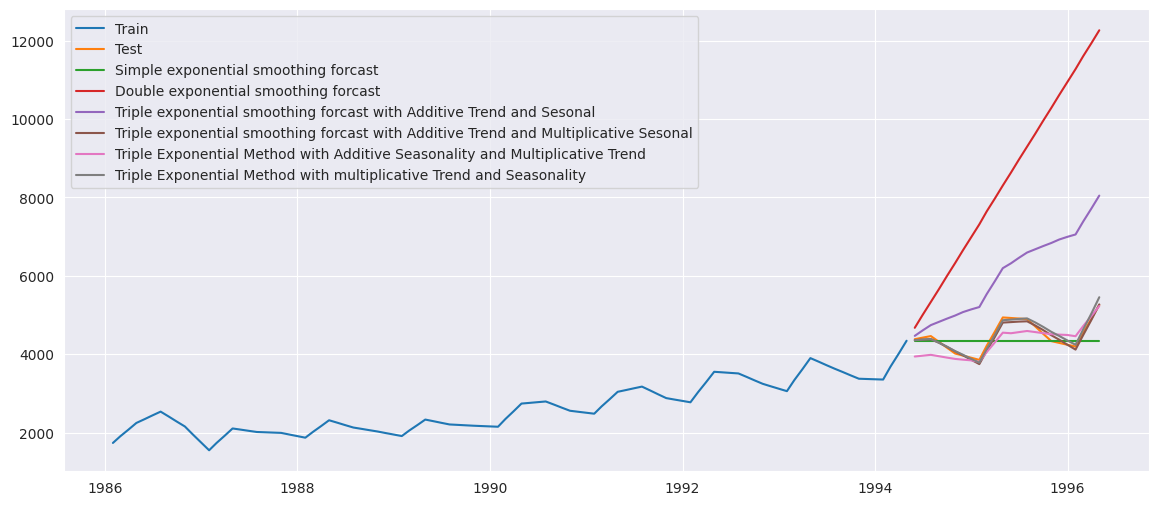

In [87]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [88]:
#Comparing the results

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_mul_ad,50.223974,1.487269,78.733258
1,Triple_Exp_mul,49.439105,1.807823,101.651349
2,Triple_Exp_ad_mul,165.781044,5.168784,270.084791
3,Simple_Exp,129.379514,6.619719,381.954224
4,Triple_Exp_ad,44.265365,35.695713,1828.476772
5,Double_Exp,108.708553,89.493161,4549.832594


In [89]:
#Visualizing Models Performance

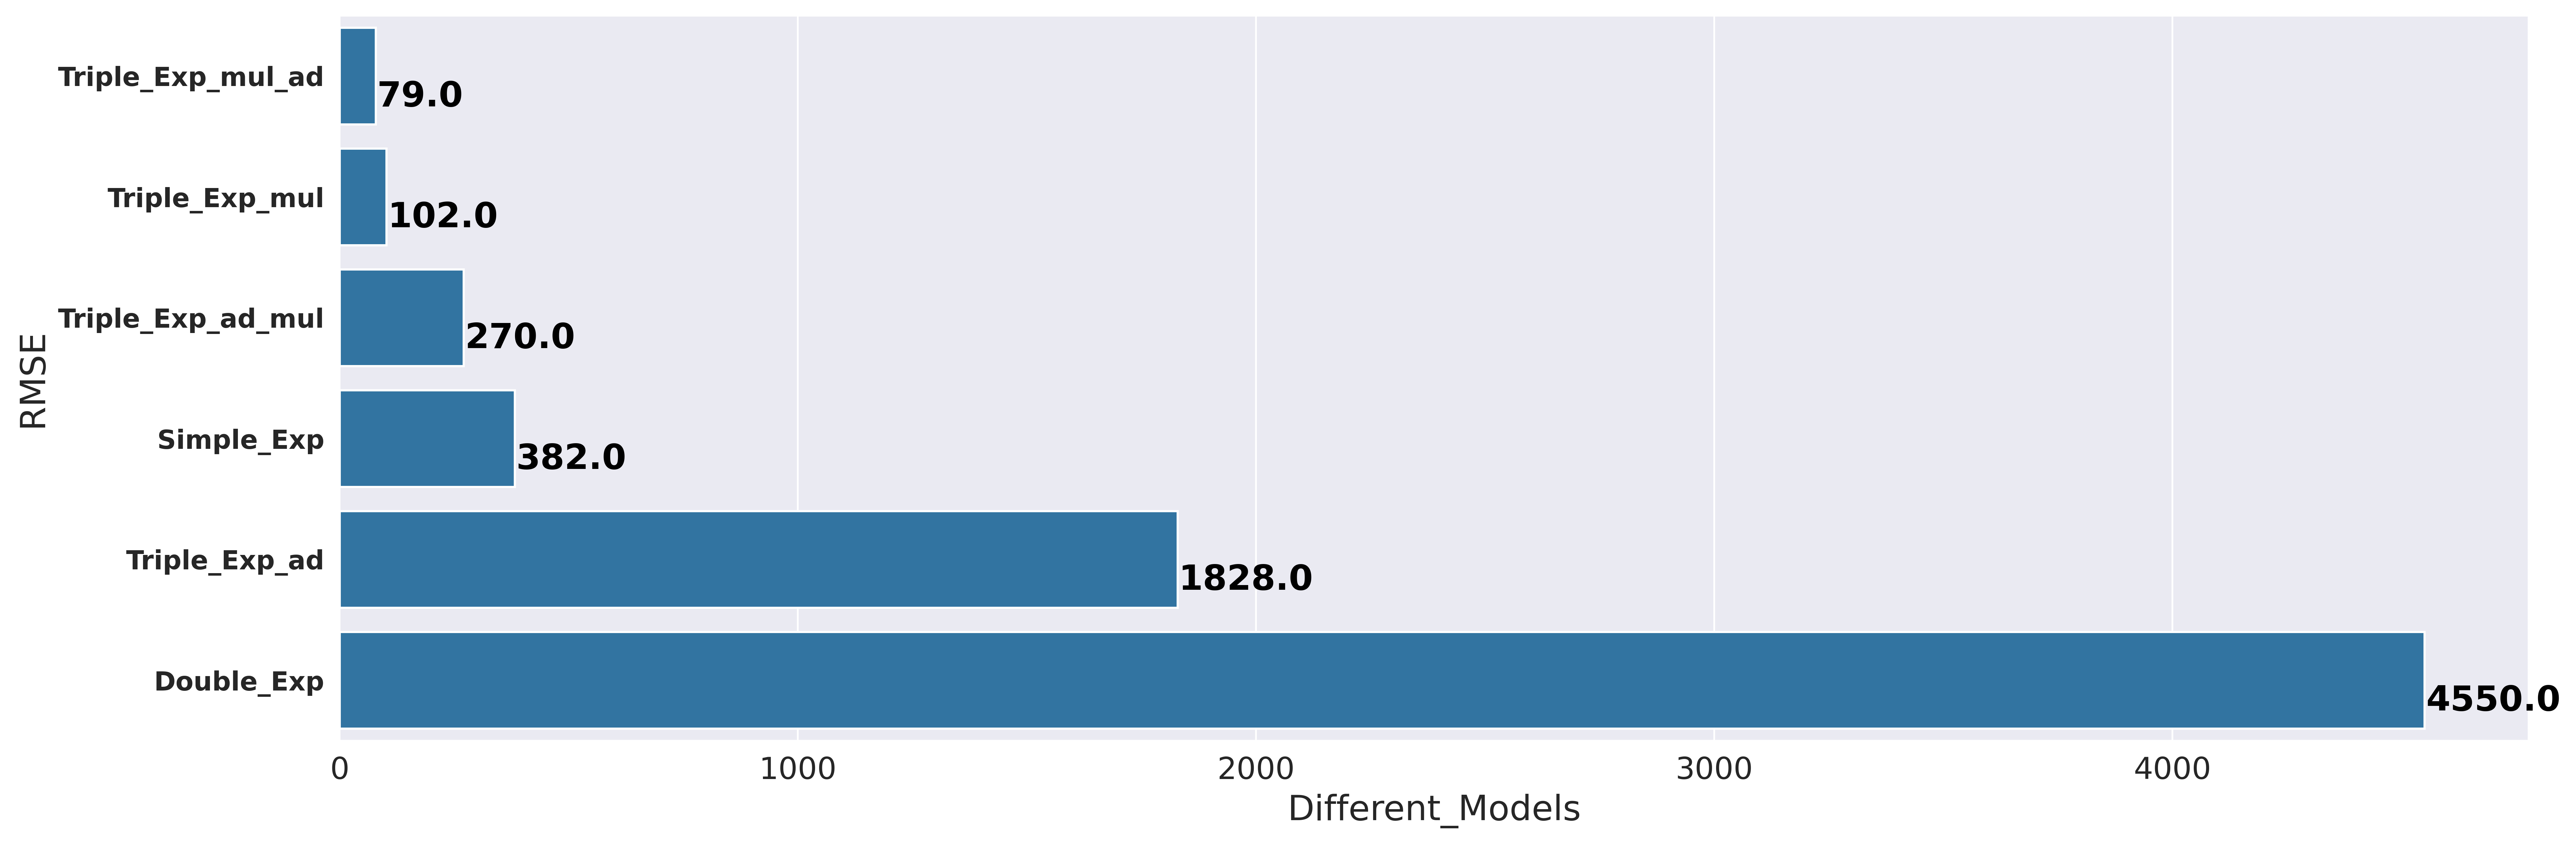

In [90]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

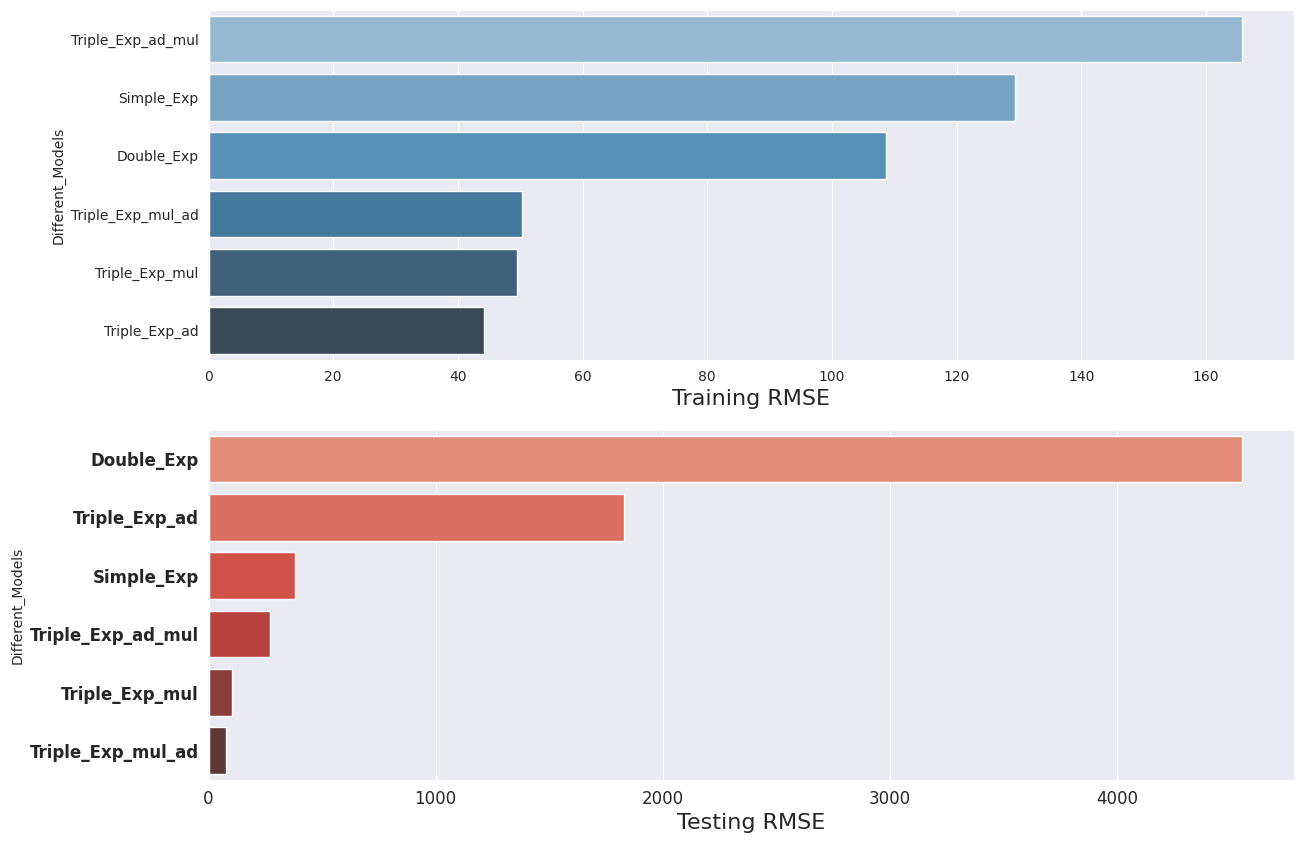

In [91]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=12)
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

In [92]:
#----------------------------Autoregressive Integrated Moving Averages (ARIMA)--------------------------

In [93]:
#Test of Stationarity

In [94]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
'''
Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05
'''

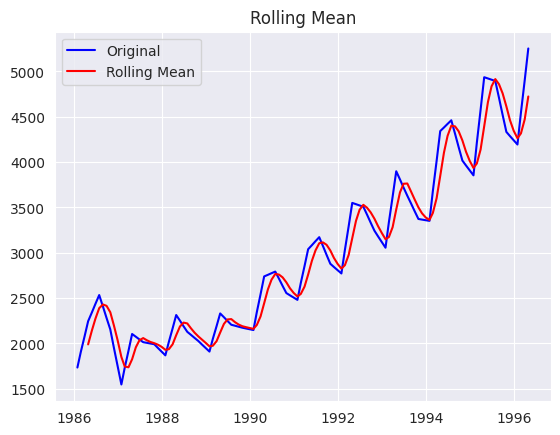

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [95]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [99]:
'''
Data Pre-processing for Model Driven Techniques
Creating Dummy Variables of the Categorical Feature Month of Date Time feature
'''

'\nData Pre-processing for Model Driven Techniques\nCreating Dummy Variables of the Categorical Feature Month of Date Time feature\n'

In [100]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


<Axes: xlabel='month', ylabel='year'>

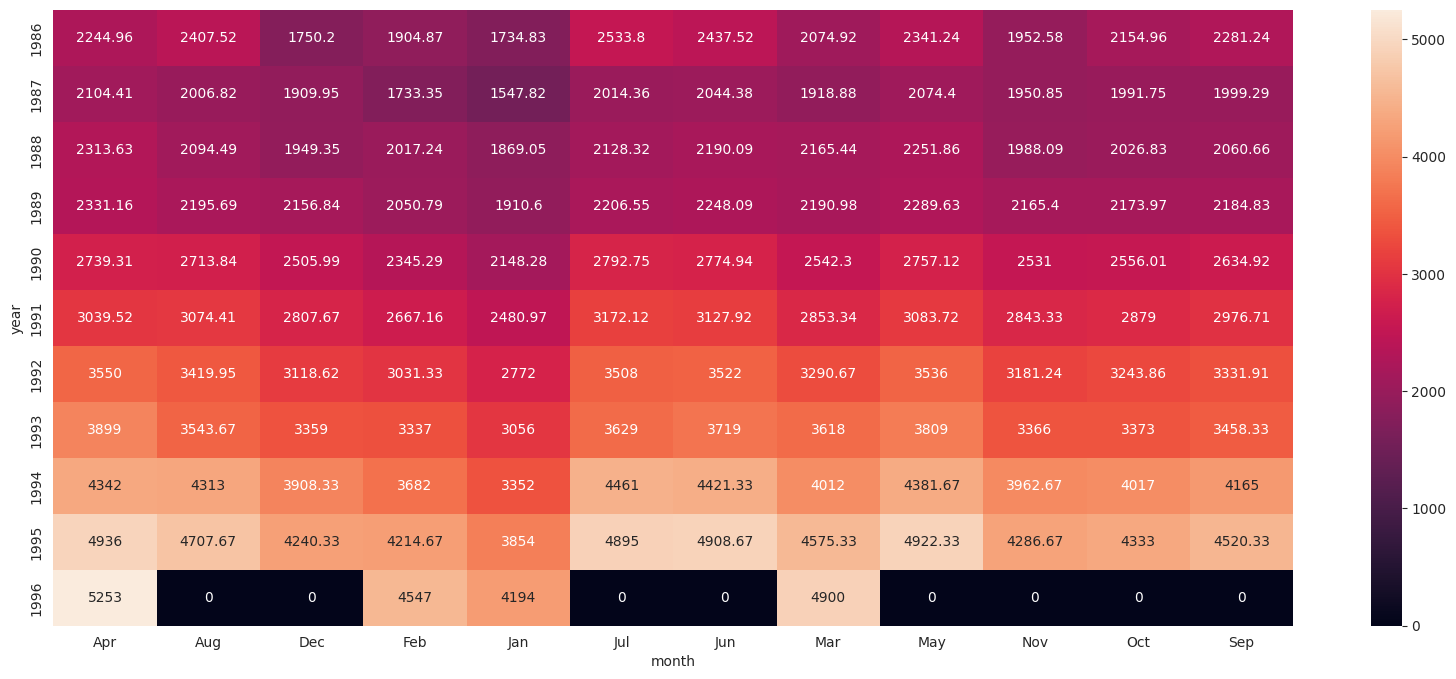

In [101]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

In [102]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [96]:
#-------------------------Model Building----------------------------------

In [97]:
#Building Ordinary Square Model (Linear Model)

In [103]:
#Linear Model
import statsmodels.formula.api as smf

linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668942

In [104]:
#Exponential

Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.326802509923

In [105]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     406.5
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.20e-36
Time:                        15:35:05   Log-Likelihood:                 84.607
No. Observations:                 100   AIC:                            -165.2
Df Residuals:                      98   BIC:                            -160.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4782      0.021    353.829      0.000       7.436       7.520
t              0.0073      0.000     20.162      0.000       0.007       0.008
==============================================================================
Omnibus:                        6.147   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.627
Skew:                           0.561   Prob(JB):                       0.0600
Kurtosis:                       3.301   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
#Quadratic

Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

371.29418344986675

In [107]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     325.2
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           9.85e-44
Time:                        15:36:21   Log-Likelihood:                -684.82
No. Observations:                 100   AIC:                             1376.
Df Residuals:                      97   BIC:                             1383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2022.9480     70.858     28.549      0.000    1882.314    2163.582
t             -2.7554      3.238     -0.851      0.397      -9.183       3.672
t_squared      0.2217      0.031      7.136      0.000       0.160       0.283
==============================================================================
Omnibus:                        3.492   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.371
Skew:                           0.193   Prob(JB):                        0.306
Kurtosis:                       2.352   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
#Additive seasonality

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea


1837.7879723483793

In [109]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6210
Date:                Wed, 03 Apr 2024   Prob (F-statistic):              0.806
Time:                        15:38:03   Log-Likelihood:                -783.17
No. Observations:                 100   AIC:                             1590.
Df Residuals:                      88   BIC:                             1622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2431.1678     60.077     40.467      0.000    2311.777    2550.559
Jan         -112.1065    208.114     -0.539      0.591    -525.689     301.476
Feb           98.7249    208.114      0.474      0.636    -314.858     512.308
Mar          309.5564    208.114      1.487      0.140    -104.026     723.139
Apr          520.3878    208.114      2.500      0.014     106.805     933.971
May          336.7034    219.714      1.532      0.129     -99.932     773.339
Jun          326.8245    219.714      1.488      0.140    -109.811     763.460
Jul          316.9457    219.714      1.443      0.153    -119.690     753.581
Aug          250.8819    219.714      1.142      0.257    -185.753     687.517
Sep          184.8182    219.714      0.841      0.403    -251.817     621.453
Oct          118.7544    219.714      0.540      0.590    -317.881     555.390
Nov           66.1439    219.714      0.301      0.764    -370.491     502.779
Dec           13.5333    219.714      0.062      0.951    -423.102     450.168
==============================================================================
Omnibus:                       30.612   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.038
Skew:                           0.459   Prob(JB):                       0.0109
Kurtosis:                       1.848   Cond. No.                     9.21e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [110]:
#Additive Seasonality Quadratic

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.8049881036695

In [111]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     138.2
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.95e-52
Time:                        15:40:07   Log-Likelihood:                -632.59
No. Observations:                 100   AIC:                             1293.
Df Residuals:                      86   BIC:                             1330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1865.7939     41.512     44.946      0.000    1783.271    1948.316
t             -2.9439      2.056     -1.432      0.156      -7.032       1.144
t_squared      0.2253      0.020     11.418      0.000       0.186       0.265
Jan         -159.7690     46.717     -3.420      0.001    -252.640     -66.898
Feb           31.7000     46.733      0.678      0.499     -61.202     124.602
Mar          222.7184     46.754      4.764      0.000     129.774     315.663
Apr          413.2862     46.781      8.834      0.000     320.288     506.284
May          372.3785     49.451      7.530      0.000     274.074     470.683
Jun          344.0384     49.465      6.955      0.000     245.706     442.371
Jul          315.2478     49.481      6.371      0.000     216.884     413.612
Aug          229.8216     49.499      4.643      0.000     131.421     328.222
Sep          143.9448     49.519      2.907      0.005      45.505     242.385
Oct           57.6174     49.541      1.163      0.248     -40.867     156.102
Nov          -15.7075     49.565     -0.317      0.752    -114.240      82.825
Dec          -89.4829     49.592     -1.804      0.075    -188.068       9.102
==============================================================================
Omnibus:                        0.473   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.611
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.617   Cond. No.                     9.11e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.47e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [112]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1904.7944171920315

In [113]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Wed, 03 Apr 2024   Prob (F-statistic):              0.767
Time:                        15:40:44   Log-Likelihood:                 6.6723
No. Observations:                 100   AIC:                             10.66
Df Residuals:                      88   BIC:                             41.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2447      0.022    324.766      0.000       7.200       7.289
Jan            0.4719      0.077      6.107      0.000       0.318       0.626
Feb            0.5592      0.077      7.236      0.000       0.406       0.713
Mar            0.6393      0.077      8.273      0.000       0.486       0.793
Apr            0.7134      0.077      9.232      0.000       0.560       0.867
May            0.6582      0.082      8.068      0.000       0.496       0.820
Jun            0.6547      0.082      8.025      0.000       0.493       0.817
Jul            0.6508      0.082      7.977      0.000       0.489       0.813
Aug            0.6277      0.082      7.694      0.000       0.466       0.790
Sep            0.6038      0.082      7.401      0.000       0.442       0.766
Oct            0.5791      0.082      7.098      0.000       0.417       0.741
Nov            0.5558      0.082      6.812      0.000       0.394       0.718
Dec            0.5309      0.082      6.508      0.000       0.369       0.693
==============================================================================
Omnibus:                       74.329   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.756
Skew:                           0.261   Prob(JB):                       0.0125
Kurtosis:                       1.648   Cond. No.                     9.21e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [114]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

396.41978173823406

In [115]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     61.10
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           4.29e-37
Time:                        15:41:23   Log-Likelihood:                 114.86
No. Observations:                 100   AIC:                            -203.7
Df Residuals:                      87   BIC:                            -169.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9000      0.015    450.015      0.000       6.870       6.931
t              0.0074      0.000     25.888      0.000       0.007       0.008
Jan            0.4543      0.026     17.240      0.000       0.402       0.507
Feb            0.5342      0.026     20.263      0.000       0.482       0.587
Mar            0.6069      0.026     23.011      0.000       0.554       0.659
Apr            0.6736      0.026     25.526      0.000       0.621       0.726
May            0.6553      0.028     23.563      0.000       0.600       0.711
Jun            0.6445      0.028     23.171      0.000       0.589       0.700
Jul            0.6332      0.028     22.759      0.000       0.578       0.688
Aug            0.6027      0.028     21.656      0.000       0.547       0.658
Sep            0.5714      0.028     20.523      0.000       0.516       0.627
Oct            0.5392      0.028     19.360      0.000       0.484       0.595
Nov            0.5085      0.028     18.246      0.000       0.453       0.564
Dec            0.4763      0.028     17.077      0.000       0.421       0.532
==============================================================================
Omnibus:                       14.672   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.352
Skew:                           0.801   Prob(JB):                     0.000171
Kurtosis:                       4.264   Cond. No.                     8.46e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.73e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [116]:
#The best model we have got so far with the lowest RMSE and lowest MAPE.